##### Boston Housing Price dataSet
The dataset we’ll use has an interesting difference from the two previous examples. It has relatively few data points: only 506, split between 404 training samples and 102 test samples. And each feature in the input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between 0 and 1; others take values between 1 and 12, others between 0 and 100, and so on.

In [1]:
from keras.datasets import boston_housing

Using TensorFlow backend.


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import numpy as np
import pandas as pd
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# restore np.load for future normal usage
np.load = np_load_old

In [4]:
train_data.shape,len(train_labels), test_data.shape, len(test_labels)

((404, 13), 404, (102, 13), 102)

In [5]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [6]:
min(train_labels), max(train_labels), np.mean(train_labels)

(5.0, 50.0, 22.395049504950492)

In [7]:
# Preparing the dataset
#Normalizing the dataset. convert each feature to mean = 0 and std.dev =1
train_mean = train_data.mean(axis=0)
train_data -=train_mean
train_std = train_data.std(axis=0)
train_data /= train_std

#Note that the quantities used for normalizing the test data are computed using the training data.
#You should never use in your workflow any quantity computed on the test data,
#even for something as simple as data normalization.

test_data -= train_mean
test_data /= train_std

In [8]:
# Building the model
from keras import layers
from keras import models
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(13,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [9]:
import numpy as np
k = 4 
num_val_samples = len(train_data) // k 
num_epochs = 100 
all_scores = []

In [10]:
num_epochs = 500 
all_mae_histories = []
for i in range(k):
    print('processing fold #', i) 
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]], axis=0) 
    partial_train_targets = np.concatenate([train_labels[:i * num_val_samples],
                                            train_labels[(i + 1) * num_val_samples:]], axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets),
                    epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error'] 
    all_mae_histories.append(mae_history)



W0922 16:54:41.259291 4586943936 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 16:54:41.286464 4586943936 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 16:54:41.288563 4586943936 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0922 16:54:41.321592 4586943936 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0922 16:54:41.435086 4586943936 deprecation_wrapper.py:119] From //anac

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

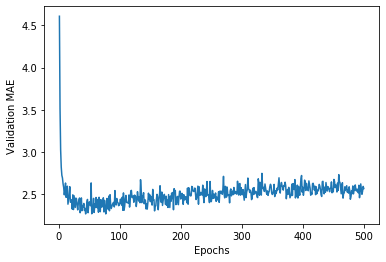

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

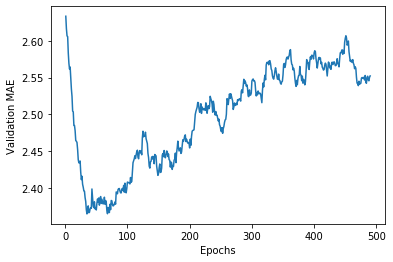

In [13]:
def smooth_curve(points, factor=0.9):
    smoothed_points = [] 
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point) 
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history) 
plt.xlabel('Epochs') 
plt.ylabel('Validation MAE')
plt.show()

In [17]:
model = build_model()
model.fit(train_data, train_labels, epochs=70, batch_size=16, verbose=0) 
test_mse_score, test_mae_score = model.evaluate(test_data, test_labels)

102/102 [==============================] - 0s 1ms/step


In [18]:
test_mae_score

2.571209337197098

In [16]:
# We’re still off by about $2,571.